In [1]:
import sys
sys.path.insert(0, './models')

In [112]:
import tensorflow as tf
import numpy as np
import scipy.io as sio
import pywt
from utils import *
from matplotlib import pyplot as plt

In [113]:
RGB = [22, 12, 4]
h = sio.loadmat('./data/kaist1.mat')['img']
h = np.expand_dims(h,0)   

H = tf.constant( h , dtype=tf.float32)

In [276]:
def tf_dwt(inputs,  wave=w, lvl=7):
    wave = 'Haar'
    w = pywt.Wavelet(wave)
    ll = np.outer(w.dec_lo, w.dec_lo)
    lh = np.outer(w.dec_hi, w.dec_lo)
    hl = np.outer(w.dec_lo, w.dec_hi)
    hh = np.outer(w.dec_hi, w.dec_hi)
    d_temp = np.zeros((np.shape(ll)[0], np.shape(ll)[1], 1, 4))
    d_temp[::-1, ::-1, 0, 0] = ll
    d_temp[::-1, ::-1, 0, 1] = lh
    d_temp[::-1, ::-1, 0, 2] = hl
    d_temp[::-1, ::-1, 0, 3] = hh

    filts = d_temp.astype('float32')
    filts = filts[None, :, :, :, :]
    filts = tf.convert_to_tensor(filts, name='filter')
    
    sz = 2 * (len(w.dec_lo) // 2 - 1)
    inputs = tf.pad(inputs, tf.constant(
        [[0, 0], [sz, sz], [sz, sz], [0, 0]]), mode="REFLECT")
    inputs = tf.expand_dims(inputs, 1)

    inputs = tf.split(inputs, [1]*int(inputs.shape.dims[4]), 4)
    inputs = tf.concat([x for x in inputs], 1)
    inputs = wavelet(inputs, filts, lvl)
    inputs = tf.transpose(inputs, perm=[0, 2, 3, 1, 4])[:, :, :, :, 0]
    return inputs


def wavelet(inputs, filters, lvl):
    outputs = tf.nn.conv3d(inputs, filters, padding='VALID',strides=[1, 1, 2, 2, 1])
    outputs = tf.split(outputs, int(outputs.shape[-1]), -1)

    if lvl != 0:
        outputs[0] = wavelet(outputs[0], filters, lvl-1)

    outputs = tf.concat(outputs, -1)
    outputs = tf.transpose(outputs, perm=[1, 0, 4, 2, 3])
    outputs = tf.unstack(outputs, int(outputs.shape[0]), 0)
    c, _, nrows, ncols = outputs[0].shape
    h = w = nrows*2    
    
    outputs = [tf.reshape(i, [c, h//nrows, -1, nrows, ncols]) for i in outputs]
    outputs = [tf.transpose(i, perm=[0, 1, 3, 2, 4]) for i in outputs]
    outputs = [tf.reshape(i, [c, h, w]) for i in outputs]
    outputs = tf.stack(outputs, 1)
    
    outputs = tf.expand_dims(outputs, -1)
    return outputs

In [277]:
wt = tf_dwt(H,lvl=0)

print(wt.shape)

(1, 512, 512, 31)


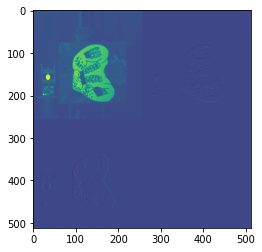

In [278]:
plt.imshow(wt[0,:,:,0])

In [293]:
def iwavelet(inputs, filters, lvl):
    out_size = tf.shape(inputs)[1]
    inputs = tf.expand_dims(inputs, 1)
    inputs = tf.split(inputs, [4] * int(int(inputs.shape.dims[4])/4), 4)
    inputs = tf.concat([x for x in inputs], 1)

    o_shape = [tf.shape(inputs)[0], tf.shape(inputs)[1],
               2*(out_size-1)+np.shape(ll)[0],
               2*(out_size-1)+np.shape(ll)[0], 1]

    outputs_3d = tf.nn.conv3d_transpose(inputs, filters,
                                        output_shape=o_shape,
                                        padding='VALID',
                                        strides=[1, 1, 2, 2, 1])

    outputs = tf.split(outputs_3d, [1] * int(int(inputs.shape.dims[4])/4), 1)
    outputs = tf.concat([x for x in outputs], 4)  
    outputs = tf.reshape(outputs, (tf.shape(outputs)[0], tf.shape(outputs)[2],
                                   tf.shape(outputs)[3], tf.shape(outputs)[4]))
    return outputs


def tf_idwt(y,lvl, wave='haar'):
    w = pywt.Wavelet(wave)
    ll = np.outer(w.rec_lo, w.rec_lo)
    lh = np.outer(w.rec_hi, w.rec_lo)
    hl = np.outer(w.rec_lo, w.rec_hi)
    hh = np.outer(w.rec_hi, w.rec_hi)
    d_temp = np.zeros((np.shape(ll)[0], np.shape(ll)[1], 1, 4))
    d_temp[:, :, 0, 0] = ll
    d_temp[:, :, 0, 1] = lh
    d_temp[:, :, 0, 2] = hl
    d_temp[:, :, 0, 3] = hh
    filts = d_temp.astype('float32')
    filts = filts[None, :, :, :, :]
    filts = tf.convert_to_tensor(filts)
    
    print(y.shape)
    
    outputs = iwavelet(y,filts,lvl)
    
#     out_size = tf.shape(y)[1]
#     y = tf.expand_dims(y, 1)
#     inputs = tf.split(y, [4] * int(int(y.shape.dims[4])/4), 4)
#     inputs = tf.concat([x for x in inputs], 1)

#     o_shape = [tf.shape(y)[0], tf.shape(inputs)[1],
#                2*(out_size-1)+np.shape(ll)[0],
#                2*(out_size-1)+np.shape(ll)[0], 1]

#     outputs_3d = tf.nn.conv3d_transpose(inputs, filts,
#                                         output_shape=o_shape,
#                                         padding='VALID',
#                                         strides=[1, 1, 2, 2, 1])

#     outputs = tf.split(outputs_3d, [1] * int(int(y.shape.dims[4])/4), 1)
#     outputs = tf.concat([x for x in outputs], 4)  
#     outputs = tf.reshape(outputs, (tf.shape(outputs)[0], tf.shape(outputs)[2],


    return outputs

In [294]:
wtb = blockshaped(wt)
wtb = wtb[0]
wtb = tf.transpose(wtb , perm=[3,1,2,0])

iwt = tf_idwt(wtb,7)



(31, 256, 256, 4)


In [295]:
def blockshaped(arr):
    
    nrows = ncols =  int(arr.shape[1] / 2)
    
    b , h , w , _ = arr.shape
    
    arr = tf.unstack(arr, arr.shape[-1],-1)    
    arr = [ tf.reshape(x , [b,h//nrows, nrows, -1, ncols]) for x in arr ]
    arr = [ tf.transpose(x ,perm=[0,1,3 ,2,4]) for x in arr ]
    arr = [ tf.reshape( x , [b,-1,nrows,ncols]) for x in arr ]   
    
    arr = tf.stack(arr , -1)
    return arr

In [296]:
arr = h

In [297]:
block = blockshaped(arr)

In [298]:
print(block.shape)

(1, 4, 256, 256, 31)


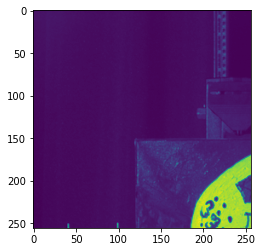

In [218]:
plt.imshow(block[0,0,:,:,0])